# **Applying DRL for FIR Filter Implementation - Stage 2** 

## Scope - *Analayzing the FIR Filters generated by the method: Direct Truncation of Fourier Series*
References:- the section 9.3 of the book, *Digital Signal Processing, signals systems and filters*, by *Andreas Antoniou*

In [1]:
import os, sys
import time
import numpy as np
from scipy.io import wavfile
from scipy.fft import fft, rfft, fftshift, fftfreq
from scipy.signal import convolve, freqz
import matplotlib.pyplot as plt

sys.path.insert(1, '../')
from helper import Spectrum

### Loading the Audio Files

In [2]:
# Let's first load the audio files
log_path = "../stage_1/audio_files/"
src_audio_name = 'vignesh'
target_audio_file = src_audio_name + '-target-MONO.wav'
jammed_audio_file = src_audio_name + '-jammed-MONO.wav'

if not os.path.exists(log_path+target_audio_file):
    raise Exception(f"the target audio signal, {log_path+target_audio_file}, doesn't exist.")
sampling_rate, target_signal = wavfile.read(log_path+target_audio_file)

if not os.path.exists(log_path+jammed_audio_file):
    raise Exception(f"the jammed audio signal, {log_path+jammed_audio_file}, doesn't exist.")
sampling_rate_, jammed_signal = wavfile.read(log_path+jammed_audio_file)

if sampling_rate != sampling_rate_:
    Exception(f"the two sampling rates are not equal, {sampling_rate} and {sampling_rate_}")
print(f"audio files have been successfully loaded: target - {log_path+target_audio_file}, jammed - {log_path+jammed_audio_file}")
print(f"sampling rate: {sampling_rate}Hz")


audio files have been successfully loaded: target - ../stage_1/audio_files/vignesh-target-MONO.wav, jammed - ../stage_1/audio_files/vignesh-jammed-MONO.wav
sampling rate: 44100Hz


In [125]:
# verify
_, original_signal = wavfile.read(log_path+'vignesh.wav')
# for i in range(100):
#     print(original_signal[i], target_signal[i], jammed_signal[i])
print(original_signal.dtype, target_signal.dtype, jammed_signal.dtype)

int16 int32 int32


Text(0, 0.5, 'magnitude')

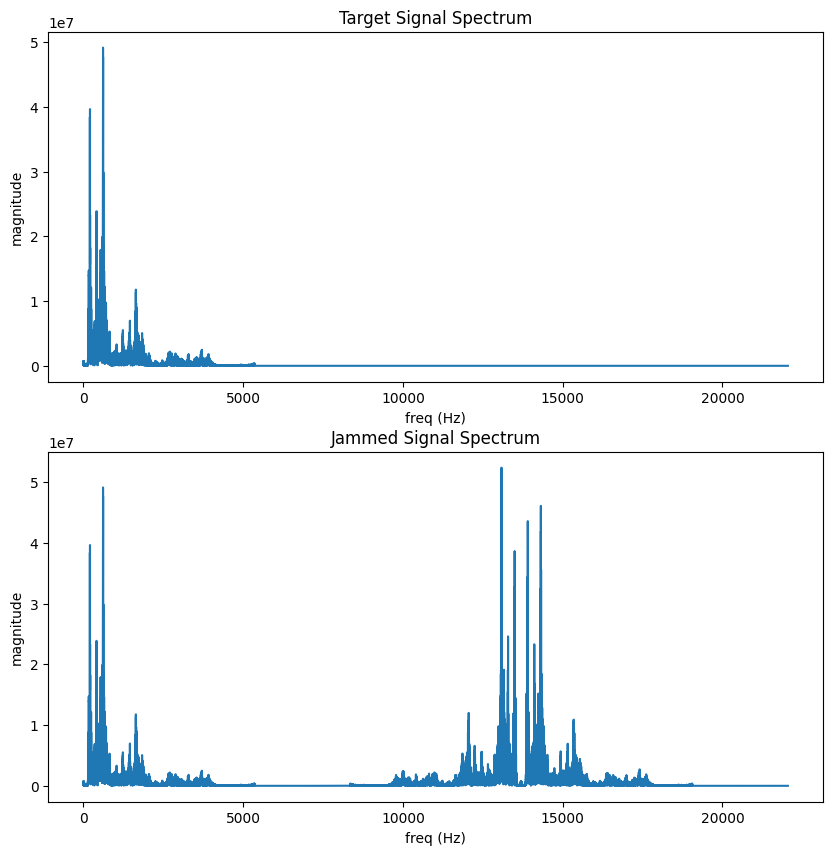

In [126]:
# visulaizing the spectrums 

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(*Spectrum(target_signal, 1/sampling_rate))
axs[0].set_title("Target Signal Spectrum")
axs[0].set_xlabel("freq (Hz)")
axs[0].set_ylabel("magnitude")
axs[1].plot(*Spectrum(jammed_signal, 1/sampling_rate))
axs[1].set_title("Jammed Signal Spectrum")
axs[1].set_xlabel("freq (Hz)")
axs[1].set_ylabel("magnitude")

### Implementing the Filters

- An ideal Low Pass Filter (LPF) with a cut-off frequnency $\omega_c$ has a passband with a unity gain and a stopband with zero gain, as represented by the formula;
$H(e^{j \omega t}) = \left \{ 
    \begin{array}{rcl}
        1 & for & |\omega| \leqslant \omega_c \\
        0 & for & \omega_c < |\omega| \leqslant \omega_s/2\\
    \end{array}\right.$. Here, $\omega_s$ is the sampling frequency of the signals.
- To achieve the above ideal frequency response, the impulse response of the filter, $h[n]$, must be symmetric and infinite in length and is given by the equation; 
$h[n] = 1/n\pi \sin (\omega_c n T)$.
- But, 

In [3]:
# helper functions for STAGE-2

def LPF(N: int, cut_off_freq: int|float, sampling_freq: int|float = 1):
    """
    Implements a Low Pass Filter with the specified cut-off frequency and the filter length using the method of direct truncation of Fourier Series. 
    (refer to the section 9.3 of the book 'Digital Signal Processing, signals systems and filters')

    :param N: filter length; must be an odd integer; if an even integer is assigned, an error will be raised. 
    :param cut_off_freq: cut-off frequency of the filter; must be in the same units as 'sampling_freq'.
    :paramm sampling_freq: sampling frequency of the signal; defaults to 1. 
    """

    if N%2==0:
        # if N is even, raise an error
        raise Exception("the filter length must be odd.")
    
    n = np.arange(-(N-1)/2, (N-1)/2+1)
    filter = 2*cut_off_freq/sampling_freq * np.sinc(2*cut_off_freq/sampling_freq * n)

    return n, filter

def apply_filter(filter, signal):
    """
    Applies the given filter on the provided signal and returns the filtered signal.
    Filtered signal would have the same length as the input signal; make sure that the provided signal is larger than the filter. 

    :param filter: an array containing the coefficients of the FIR filter
    :param signal: an array corresponding to the signal sequence 
    """

    return convolve(signal, filter, mode='same')

def mean_L1_dist(sig1, sig2):
    """
    Returns the L1 distance (Manhattan distance) of the two signals provided: sig1 and sig2.
    The two signals must of the same length; if not, a broadcasting error will be raised. 

    :param sig1: a numpy array representing the first signal
    :param sig2: a numpy array representing the second signal 
    """
    return np.sum(np.abs(sig1 - sig2)) / len(sig1)

def mean_L2_dist(sig1, sig2):
    """
    Returns the L2 distance (Euclidean) of the two signals provided: sig1 and sig2.
    The two signals must of the same length; if not, a broadcasting error will be raised. 

    :param sig1: a numpy array representing the first signal
    :param sig2: a numpy array representing the second signal 
    """
    return np.sqrt(np.sum((sig1 - sig2)**2) / len(sig1)) # RMS

def mean_Lp_dist(sig1, sig2, p: int):
    """
    Returns the Lp distance of the two signals provided: sig1 and sig2.
    The two signals must of the same length; if not, a broadcasting error will be raised. 

    :param sig1: a numpy array representing the first signal
    :param sig2: a numpy array representing the second signal 
    """
    return (np.sum(np.abs(sig1 - sig2)**p) / len(sig1))**(1/p)


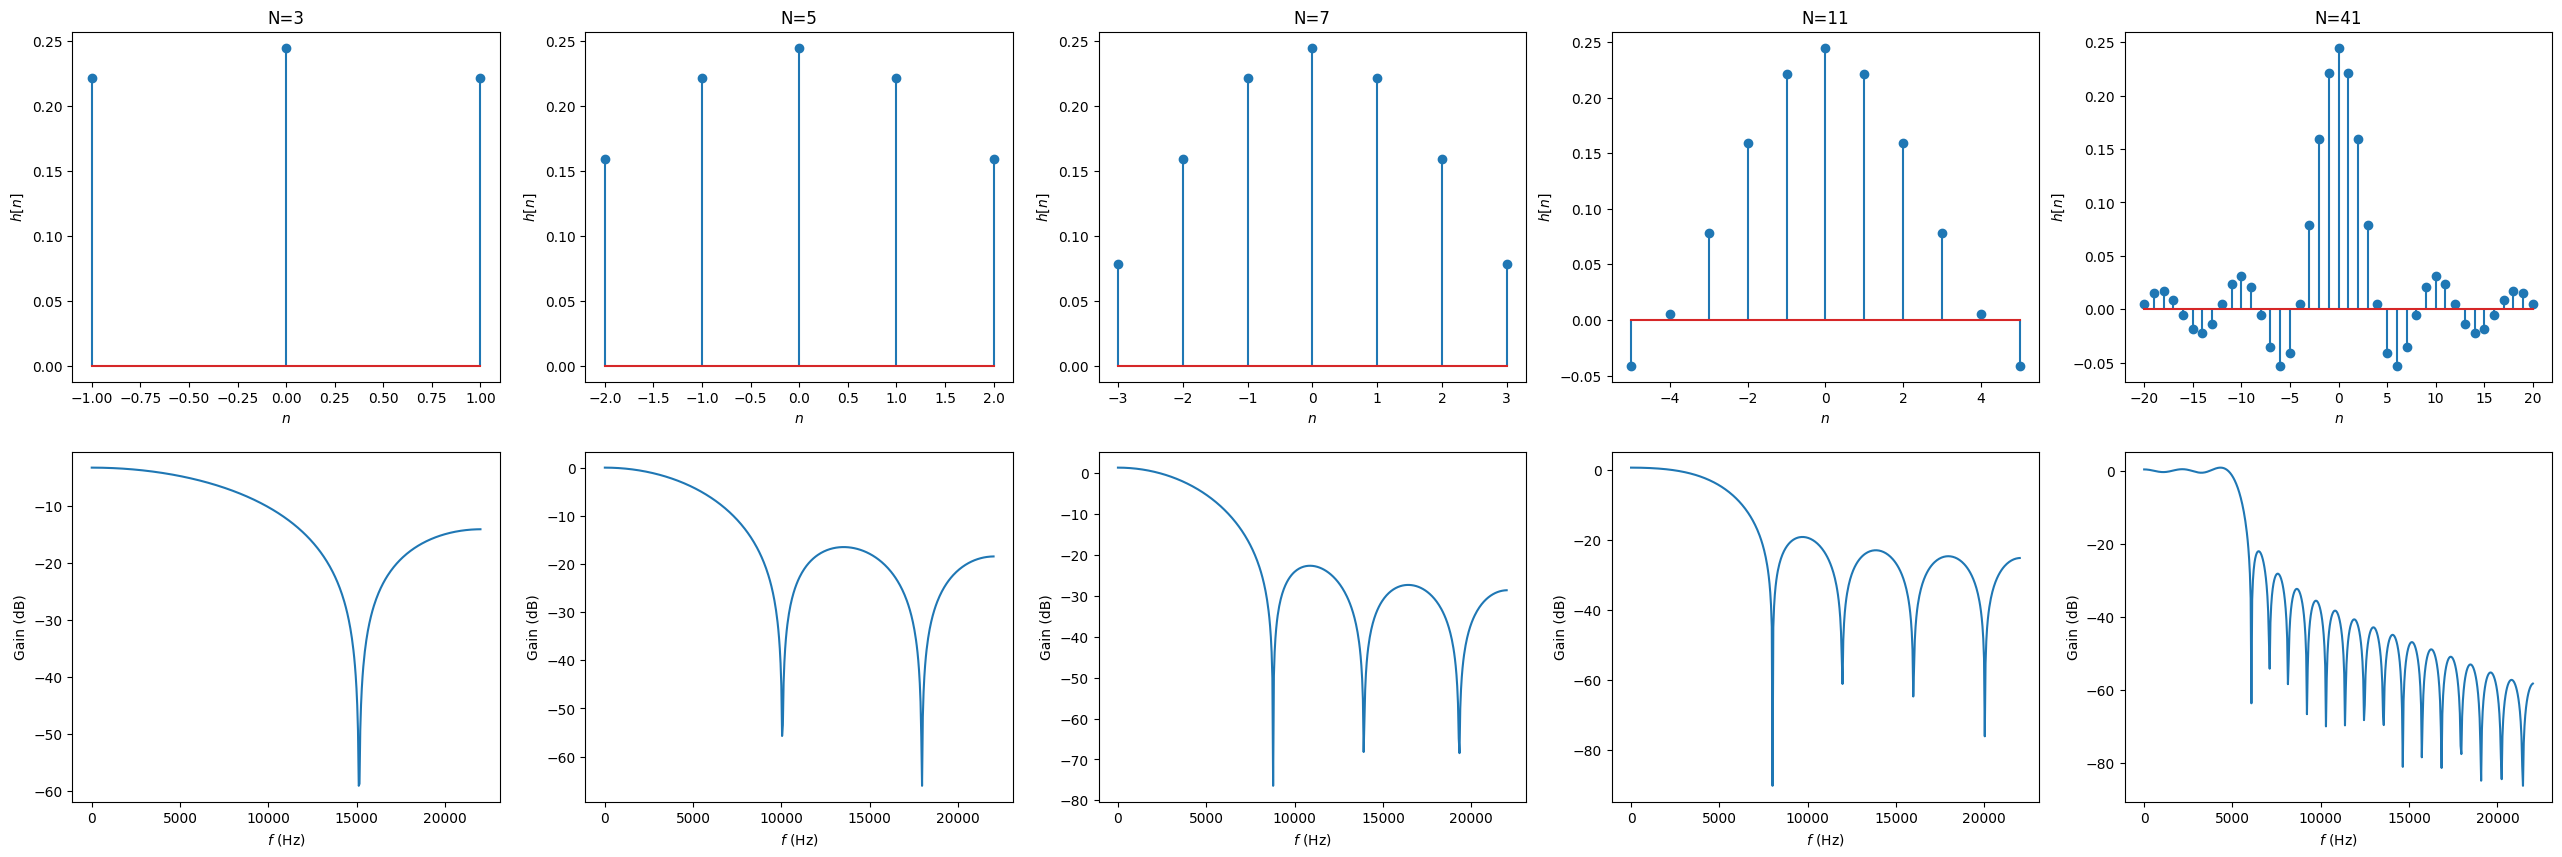

In [4]:
# analyzing filters with different lengths and their frequency responses 

# sampling_rate = 44_100
cut_off_freq = 5400 # Hz

fig, axs = plt.subplots(2, 5, figsize=(32, 10))
for i, N in enumerate([3, 5, 7, 11, 41]):
    n, filter = LPF(N, cut_off_freq, sampling_rate)
    axs[0][i].stem(n, filter)
    axs[0][i].set_title(f"N={N}")
    axs[0][i].set_xlabel("$n$")
    axs[0][i].set_ylabel("$h[n]$")

    # plotting the frequency response of the filter
    w, h = freqz(filter, fs=sampling_rate)
    axs[1][i].plot(w, 20*np.log10(np.abs(h)))
    axs[1][i].set_xlabel("$f$ (Hz)")
    axs[1][i].set_ylabel("Gain (dB)")


### Applying Filters to the Selected Jammed Audio Signal

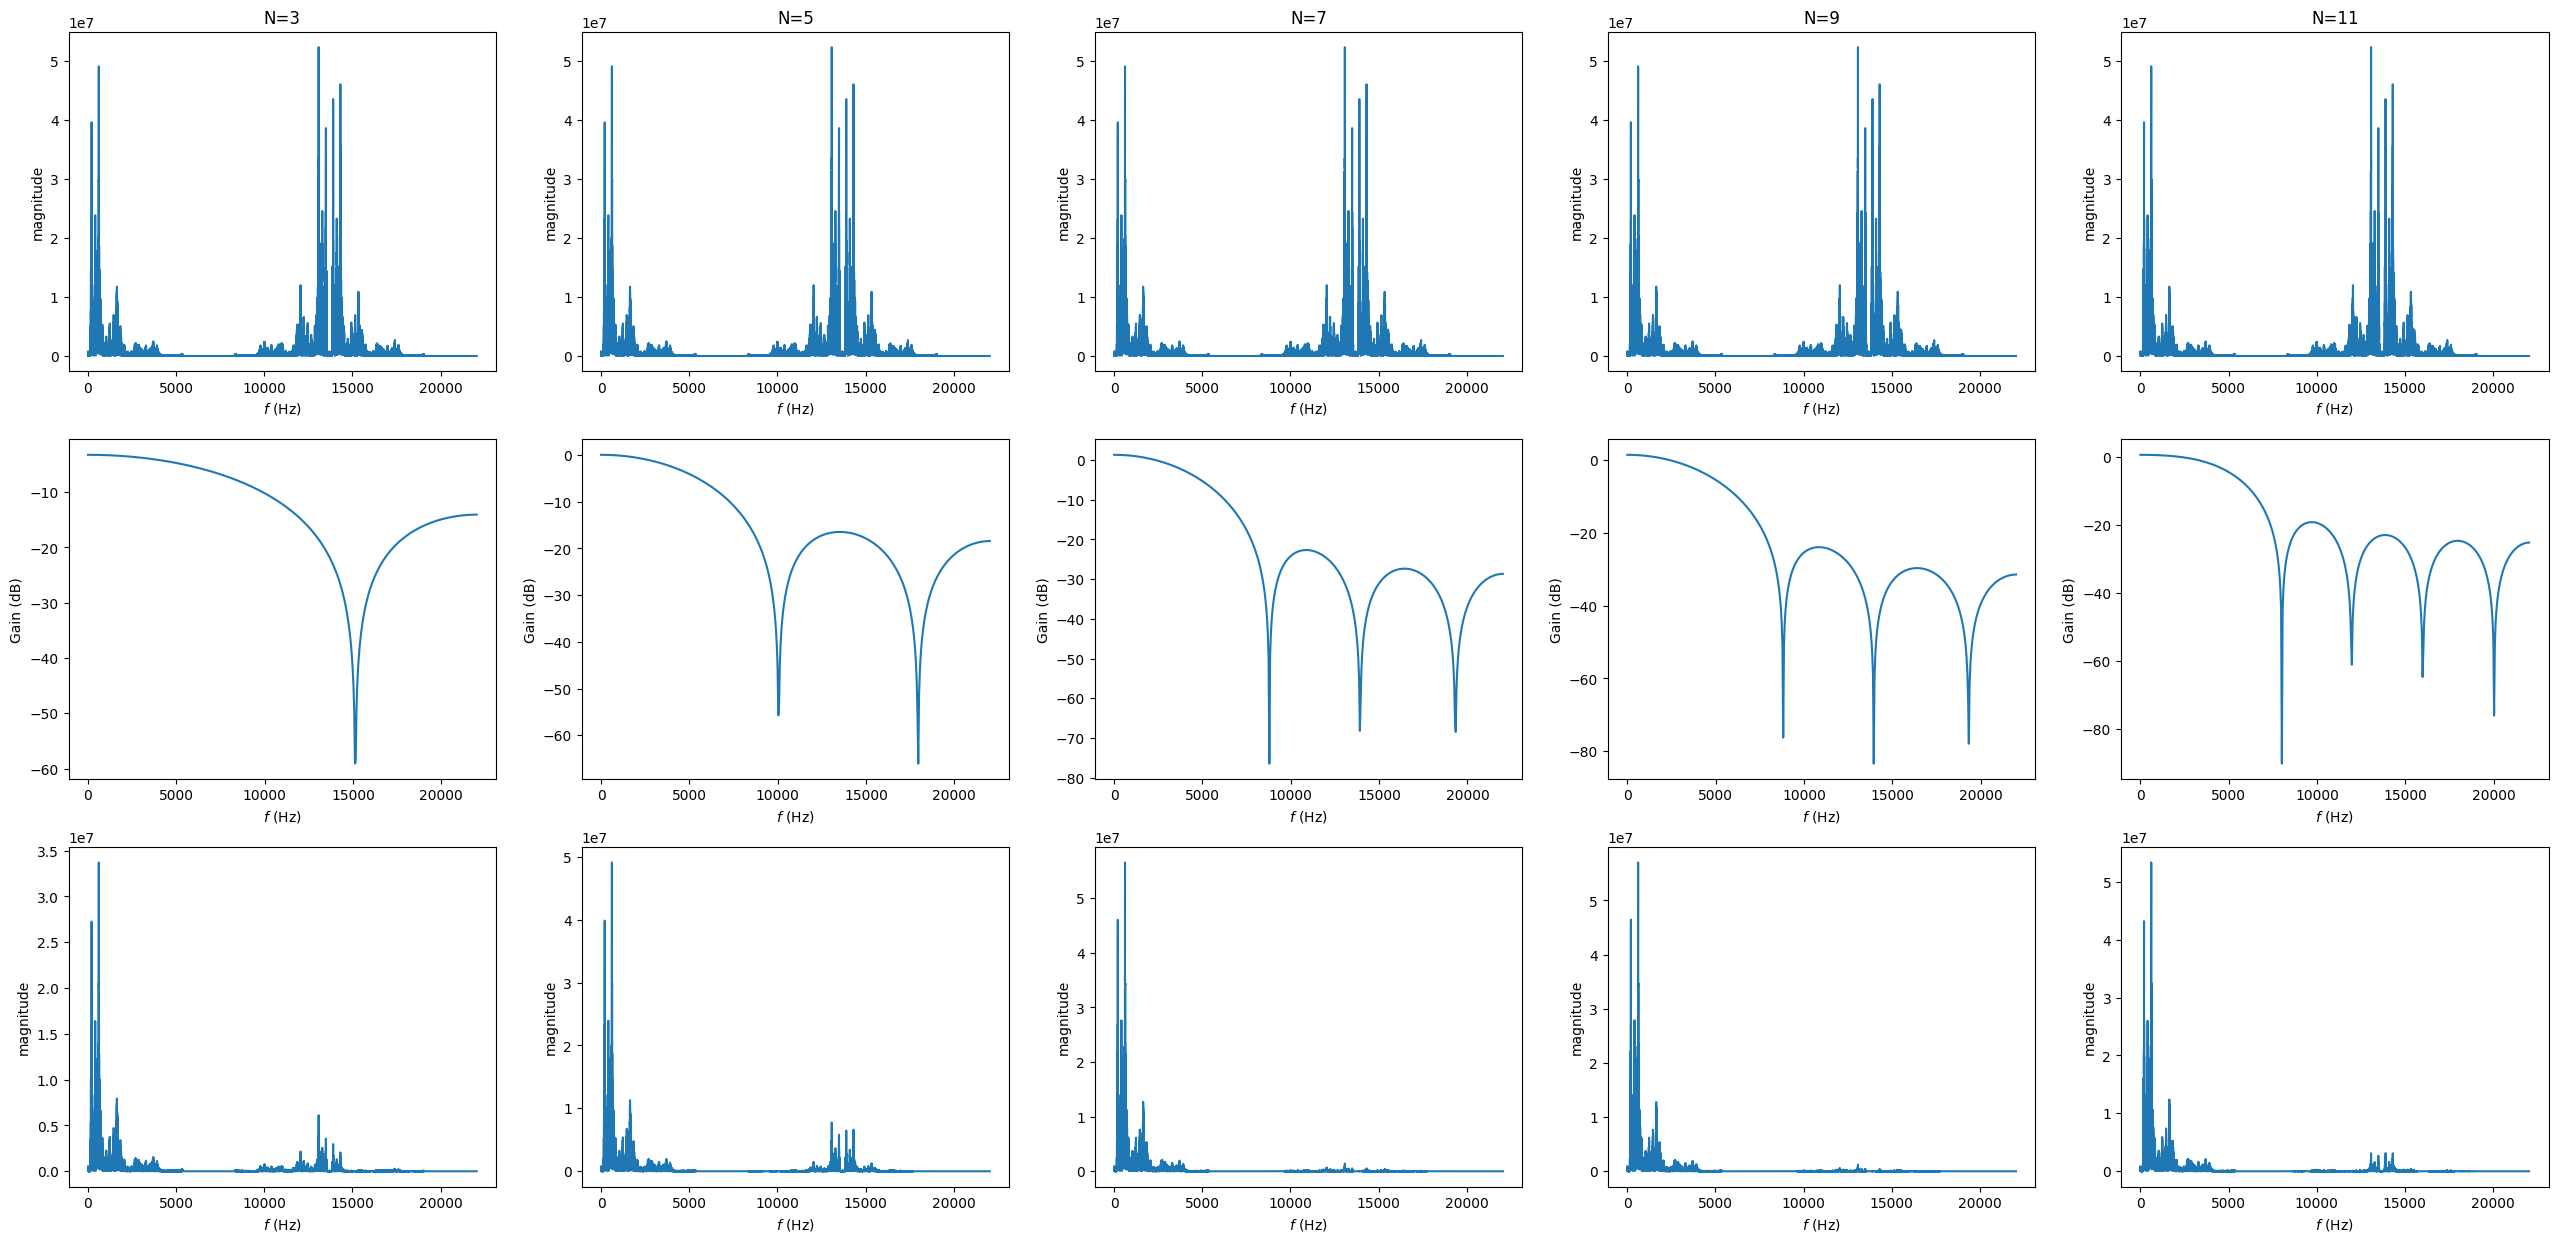

In [129]:
# peform filtering 
fig, axs = plt.subplots(3, 5, figsize=(32, 15))

for i, N in enumerate([3, 5, 7, 9, 11]):
    n, filter = LPF(N, cut_off_freq, sampling_rate)
    filtered_signal = apply_filter(filter, jammed_signal)
    Spectrum(filtered_signal, sampling_space=1/sampling_rate)

    # plotting the signal frequency spectrums before filtering
    axs[0][i].set_title(f"N={N}")
    axs[0][i].plot(*Spectrum(jammed_signal, sampling_space=1/sampling_rate))
    axs[0][i].set_xlabel("$f$ (Hz)")
    axs[0][i].set_ylabel("magnitude")

    # plotting the frequency response of the filter
    w, h = freqz(filter, fs=sampling_rate)
    axs[1][i].plot(w, 20*np.log10(np.abs(h)))
    axs[1][i].set_xlabel("$f$ (Hz)")
    axs[1][i].set_ylabel("Gain (dB)")

    # plotting the frequency spectrums after filtering
    axs[2][i].plot(*Spectrum(filtered_signal, sampling_space=1/sampling_rate))
    axs[2][i].set_xlabel("$f$ (Hz)")
    axs[2][i].set_ylabel("magnitude")


### Evaluating the Filters 
- Evaluation of the performance of a filter can be done by estimating the distance/differene between the target output and the filtered output signals. 
- Since all audio signals are simply 1-D sequences, they can be interpreted as vectors; then, intiutively, to estimate the difference between two signals, $L^p$ distances can be used. 
- For simplicity, we will mainly focus on the most common $L^1$ (Manhattan distance) and $L^2$ (Eucledian distance) distances in this case. 
- However, the difference or the error value obtained by this method grows with the signal sequence length; therefore, to have a performance metric independent of the processed signals, we will take the mean $L^p$ distance between individiual time samples of target and filtered signals (this is equivalent to an RMS (root mean square) error when $L^2$ norms are considered).
- Comming up with an appropriate and a reliable performance metric for the filter peformance is vital because this notion of better filters will be later exploited to derive the rewards in the RL process.

average sample value of the target signal: 2569.8045517160526


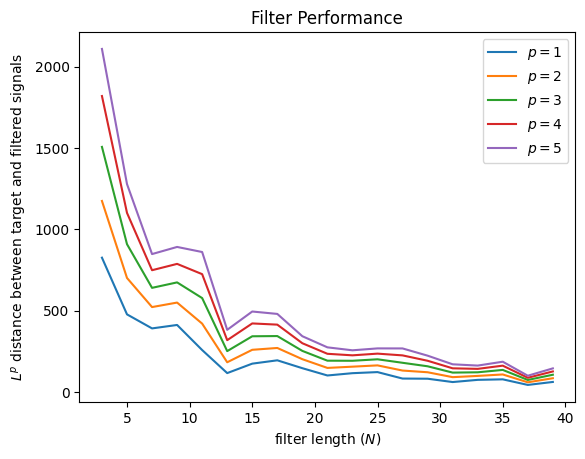

In [130]:
# evaluating the filering process 
print(f"average sample value of the target signal: {np.mean(np.abs(target_signal))}")
Lp_distances = np.zeros((5, len(range(3, 41, 2))))
for i, N in enumerate(range(3, 41, 2)):
    _, filter = LPF(N, cut_off_freq=5400, sampling_freq=sampling_rate)
    filtered_signal = apply_filter(filter, jammed_signal)
    Lp_distances[:, i] = [mean_Lp_dist(target_signal, filtered_signal, p=order) for order in range(1, 5+1)]

plt.plot(range(3, 41, 2), Lp_distances.T, label=["$p=1$", "$p=2$", "$p=3$", "$p=4$", "$p=5$"])
plt.title("Filter Performance")
plt.xlabel("filter length ($N$)")
plt.ylabel("$L^p$ distance between target and filtered signals")
plt.legend()